Copyright (C) 2016 Glencoe Software, Inc.
All Rights Reserved.

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 2 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License along
with this program; if not, write to the Free Software Foundation, Inc.,
51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.


# Working with the analytical data stored on the OMERO server


* Connect to OMERO server
* Request [OMERO.table](https://www.openmicroscopy.org/site/support/omero5.2/developers/Python.html#omero-tables) object
* Check the header
* Read in two columns from the server
* Scatter plot ([matplotlib](http://matplotlib.org/))
* Heatmaps on the Plate grid ([matplotlib](http://matplotlib.org/))

This notebook demonstarates how to retrieve analytical data stored as an [OMERO.table](http://downloads.openmicroscopy.org/omero/5.2.4/api/slice2html/omero/grid/Table.html) from the [OMERO.server](http://www.openmicroscopy.org/site/products/omero) and visualise it using [matplotlib](http://matplotlib.org/).

OMERO.tables provide a way to efficiently store large, tabular results within OMERO.
The OMERO.tables [installation guide](https://www.openmicroscopy.org/site/support/omero5.2/sysadmins/server-tables.html) and the [API](https://www.openmicroscopy.org/site/support/omero5.2/developers/Tables.html) documentations are provided by the OME team.

The video tutorial for this notebook can be found on [Glencoe Software, Inc.](http://glencoesoftware.com/webinars.html) website (look for: OMERO Plus for High Content Screening & Analysis: The Gold Standard in Data Management & Integration).

### Connect to the OMERO server

In [1]:
import omero
from omero.gateway import BlitzGateway
import gs_analytics

import pprint

In [9]:
from getpass import getpass
conn = BlitzGateway(
    raw_input("Username: "), getpass("OMERO Password: "),
    host=raw_input("Host: "), port=int(raw_input("Port: ")))
conn.connect()

Username: your_username
OMERO Password: ········
Host: your.server.address
Port: 4064


False

### Request OMERO.table object

In [3]:
shared_resources = conn.c.sf.sharedResources()
original_file_id = raw_input("OMERO.table file id: ")
original_file = omero.model.OriginalFileI(original_file_id, False)
omero_table = shared_resources.openTable(original_file)
column_names = [col.name for col in omero_table.getHeaders()]
print "First ten columns:\n%s" % pprint.pformat(column_names[0:9])

OMERO.table file id: 65964
First ten columns:
['Count_DistCytoplasm',
 'Count_DistanceCells',
 'Count_Nuclei',
 'Count_PropCells',
 'Count_PropCytoplasm',
 'FileName_rawDNA',
 'FileName_rawGFP',
 'ImageNumber',
 'Mean_Nuclei_AreaShape_Area']


### Request actual data

In [4]:
number_of_rows = omero_table.getNumberOfRows()
selected_columns = [
    column_names.index('ImageNumber'),
    column_names.index('Count_PropCells')]
data = omero_table.read(selected_columns, 0, number_of_rows)
print "Received data for %i columns with %s rows." % \
    (len(data.columns), len(data.columns[0].values))

Received data for 2 columns with 96 rows.


### Scatter plot

In [5]:
%matplotlib notebook

'matplotlib (1.3.1)'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

from IPython.display import display, HTML

<IPython.core.display.Javascript object>


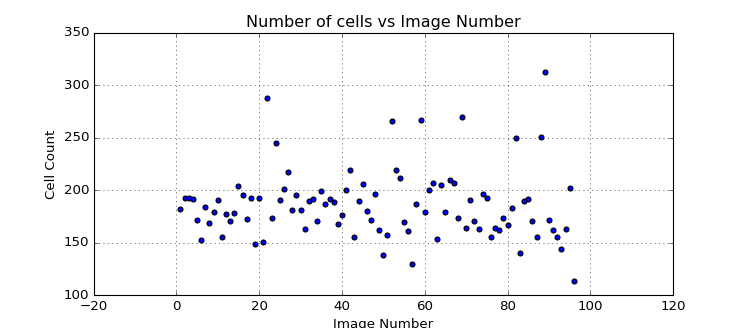

In [6]:
matplotlib.rcParams['figure.figsize'] = (9.0, 4.0)
fig = plt.figure()
plt.scatter(
    [int(value) for value in data.columns[0].values],
    [float(value) for value in data.columns[1].values])
plt.xlabel('Image Number')
plt.ylabel("Cell Count")
plt.grid(True)
plt.title("Number of cells vs Image Number")
plt.show()

### A little less simple plot: Heat Maps on a Plate Grid

Plate id: 351


<IPython.core.display.Javascript object>


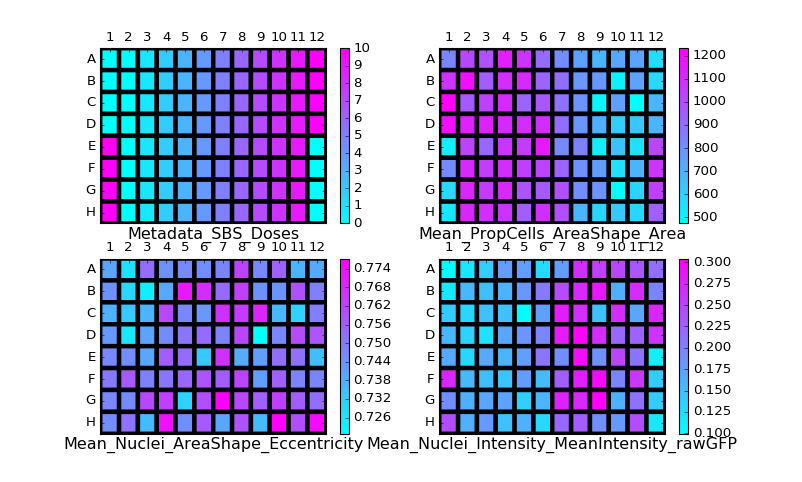

In [7]:
matplotlib.rcParams['figure.figsize'] = (9.0, 5.5)
# Create plate_layout object (Image ID to Row-Column map)
plate_id = raw_input("Plate id: ")
plate_layout = gs_analytics.get_plate_layout(conn, plate_id)
# Read in columns from the OMERO.table
selected_column_names = [
    'Metadata_SBS_Doses',
    'Mean_PropCells_AreaShape_Area',
    'Mean_Nuclei_AreaShape_Eccentricity',
    'Mean_Nuclei_Intensity_MeanIntensity_rawGFP',
    'Image']
selected_columns = [
    column_names.index(column_name) for
    column_name in selected_column_names]
data = omero_table.read(selected_columns, 0, number_of_rows)
display_matricies = []
# Display Heatmaps
fig = plt.figure()
for index in range(4):
    display_matrix = gs_analytics.build_display_matrix(
        plate_layout, data.columns[4].values, data.columns[index].values)
    ax = fig.add_subplot(2, 2, index + 1)
    im = ax.pcolor(display_matrix, cmap=cm.cool, edgecolors='k', linewidths=4)
    gs_analytics.set_axis_properties(ax)
    plt.title(selected_column_names[index], y=-0.12)
    plt.colorbar(im)
plt.show()

### Disconnect from the OMERO server

In [8]:
conn._closeSession()